# Augment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
from torch.utils.data import Dataset 
from PIL import Image
import torch
import glob
import albumentations as A
import cv2
import numpy as np
from torchvision import transforms
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
torch.cuda.set_device(0)
from torch.utils.data import Dataset
from PIL import Image
import torch.nn as nn

from torch.utils.data.dataset import random_split
class WithAubumentations(Dataset):
    def __init__(self):
        self.resize = A.Compose([
            A.Resize(256, 256),
        ])

        self.aug_transforms = A.Compose([
            #Pixel-level Transforms
            A.RandomBrightnessContrast(p=0.2),
            A.GaussNoise(p=0.2),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.2),
            # #Spatial-level Transforms
            A.HorizontalFlip(p=0.2),
            A.RandomCrop(width=256, height=256, p=0.2),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=3, p=0.2, border_mode=cv2.BORDER_CONSTANT),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
            # #Mixing-level Transforms
            # A.MixUp(p=0.2),
        ], additional_targets={'mask': 'mask'})

        self.norm = A.Compose([
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        self._segs = glob.glob("/media/mountHDD3/data_storage/biomedical_data/Dataset/BUSI/Dataset_BUSI_with_GT/*/*_mask.png")

        self._images =  [mask_images.replace("_mask", "") for mask_images in self._segs]

        print("Data Set Setting Up")
        print(len(self._images), len(self._segs))

    @staticmethod
    def process_mask(x):
        # Ensure mask is binary (0 and 1)
        x = x.to(dtype=torch.torch.float)
        return x

    def __len__(self):
        return len(self._images)
    
    def __getitem__(self, idx):
        image = Image.open(self._images[idx]).convert("RGB")
        mask = Image.open(self._segs[idx])
        img = image.convert('RGB') if image.mode == 'RGBA' else image
        msk = mask.convert('L')  # Convert mask to grayscale
        image = np.array(img)
        mask = np.array(msk)

        resized = self.resize(image=image, mask=mask)
        transformed = self.aug_transforms(image=resized['image'], mask=resized['mask'])
        transformed_img = transformed["image"]
        transformed_mask = transformed["mask"]

        torch_img = torch.from_numpy(transformed_img).permute(-1, 0, 1).float()
        torch_mask = torch.from_numpy(transformed_mask).unsqueeze(0).float()  # Add channel dimension

        return torch_img, self.process_mask(torch_mask)

Data_transfered = WithAubumentations()

train_ds, test_val = random_split(Data_transfered, [0.7, 0.3])
test_ds, val_ds = random_split(Data_transfered, [0.5, 0.5])
batch_size= 16

train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True) # Use batch size
val_dataloader = DataLoader(val_ds, batch_size=batch_size, shuffle=True) # Use batch size
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=True) # Use batch size

print("Training Samples: {}".format(len(train_ds)))
print("Testing Samples: {}".format(len(test_ds)))
print(len(Data_transfered))


/media/mountHDD2/chuyenmt/.env/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.3 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Data Set Setting Up
780 780
Training Samples: 546
Testing Samples: 390
780


/tmp/ipykernel_3183726/3117106135.py:41: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),


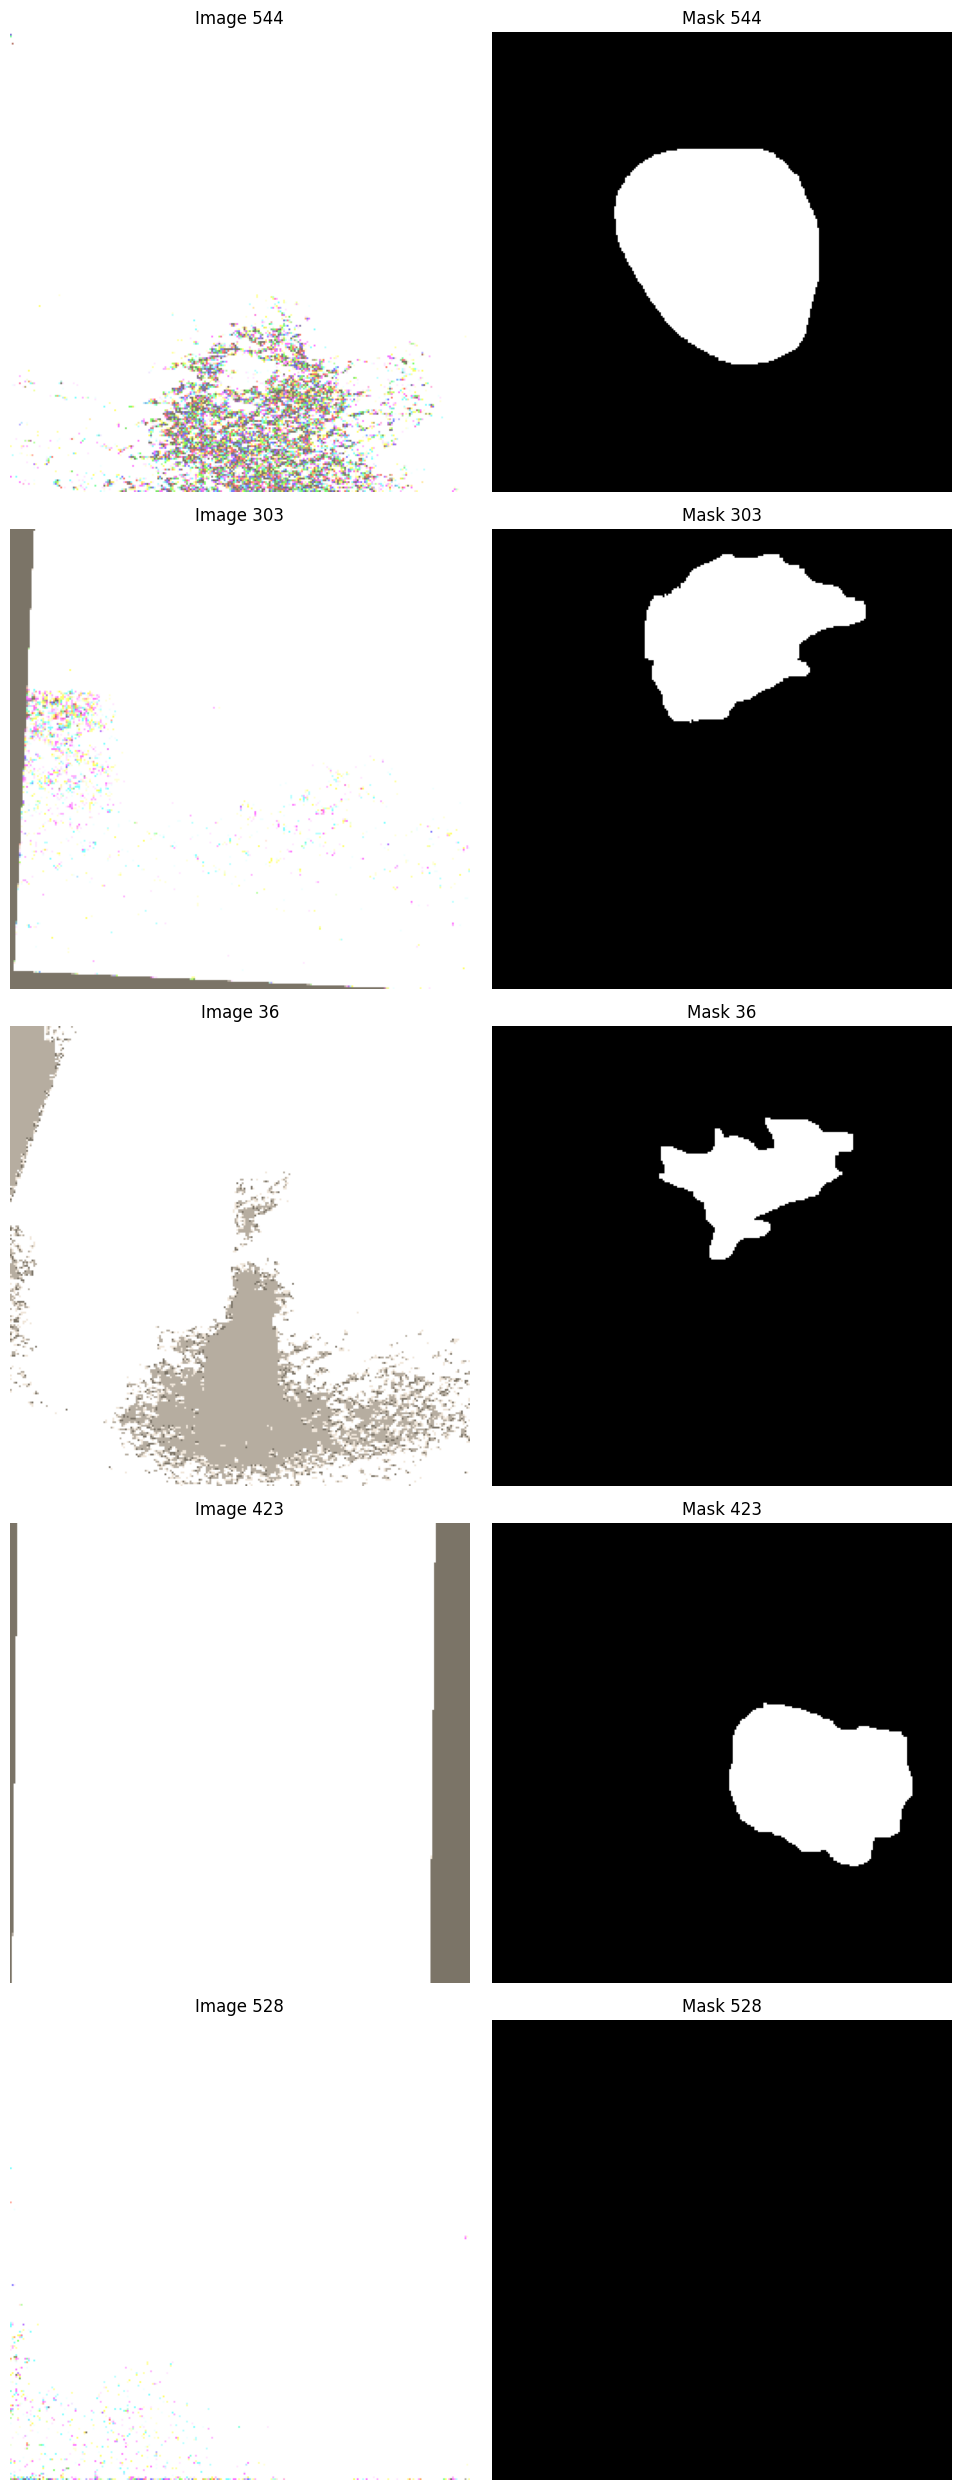

In [2]:
import matplotlib.pyplot as plt
import random
import torch

# Denormalize the image
def denormalize_image(image, mean, std):
    # Convert to [0, 1] by reversing the normalization
    for c in range(3):  # Assuming 3 channels (RGB)
        image[..., c] = image[..., c] * std[c] + mean[c]
    return image

# Function to plot image and mask
def plot_image_mask(dataset, num_samples=5):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))
    
    # Denormalization mean and std values
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    # Loop over the number of samples
    for i in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)  # Pick a random index
        image, mask = dataset[idx]  # Get image and mask
        
        # Normalize image to the [0, 1] range if it's not already
        image = image.permute(1, 2, 0).numpy()  # Convert to HWC format for plotting
        
        # Denormalize the image back to the original pixel values
        image = denormalize_image(image, mean, std)
        
        # Clip values to the valid range [0, 1] for display purposes
        image = image.clip(0, 1)

        # Plot image
        axes[i, 0].imshow(image)
        axes[i, 0].set_title(f'Image {idx}')
        axes[i, 0].axis('off')  # Hide axes
        
        # Plot mask (same process)
        axes[i, 1].imshow(mask.squeeze(), cmap='gray')  # Remove channel dimension for plotting mask
        axes[i, 1].set_title(f'Mask {idx}')
        axes[i, 1].axis('off')  # Hide axes
    
    plt.tight_layout()
    plt.show()

# Call the function to plot random images with masks
plot_image_mask(train_dataloader.dataset, num_samples=5)


# No Augment

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
torch.cuda.set_device(0)
from torch.utils.data import Dataset
from PIL import Image
import torch.nn as nn

import warnings
warnings.filterwarnings("ignore")

import glob

from sklearn.model_selection import train_test_split

In [8]:
masks = glob.glob("/media/mountHDD3/data_storage/biomedical_data/Dataset/BUSI/Dataset_BUSI_with_GT/*/*_mask.png")

In [9]:
masks[1:4]

['/media/mountHDD3/data_storage/biomedical_data/Dataset/BUSI/Dataset_BUSI_with_GT/benign/benign (27)_mask.png',
 '/media/mountHDD3/data_storage/biomedical_data/Dataset/BUSI/Dataset_BUSI_with_GT/benign/benign (388)_mask.png',
 '/media/mountHDD3/data_storage/biomedical_data/Dataset/BUSI/Dataset_BUSI_with_GT/benign/benign (326)_mask.png']

In [10]:
images = [mask_images.replace("_mask", "") for mask_images in masks]

In [11]:
series = list(zip(images, masks))

In [12]:
series[:4]

[('/media/mountHDD3/data_storage/biomedical_data/Dataset/BUSI/Dataset_BUSI_with_GT/benign/benign (222).png',
  '/media/mountHDD3/data_storage/biomedical_data/Dataset/BUSI/Dataset_BUSI_with_GT/benign/benign (222)_mask.png'),
 ('/media/mountHDD3/data_storage/biomedical_data/Dataset/BUSI/Dataset_BUSI_with_GT/benign/benign (27).png',
  '/media/mountHDD3/data_storage/biomedical_data/Dataset/BUSI/Dataset_BUSI_with_GT/benign/benign (27)_mask.png'),
 ('/media/mountHDD3/data_storage/biomedical_data/Dataset/BUSI/Dataset_BUSI_with_GT/benign/benign (388).png',
  '/media/mountHDD3/data_storage/biomedical_data/Dataset/BUSI/Dataset_BUSI_with_GT/benign/benign (388)_mask.png'),
 ('/media/mountHDD3/data_storage/biomedical_data/Dataset/BUSI/Dataset_BUSI_with_GT/benign/benign (326).png',
  '/media/mountHDD3/data_storage/biomedical_data/Dataset/BUSI/Dataset_BUSI_with_GT/benign/benign (326)_mask.png')]

In [13]:
def plot_train_label(image_mask):
    image = cv2.imread(image_mask[0])
    mask = cv2.imread(image_mask[1])
    
    f, axarr = plt.subplots(1, 3, figsize=(5, 5))
    
    axarr[0].imshow(np.squeeze(image), cmap='gray', origin='lower')
    axarr[0].set_ylabel('Axial View', fontsize=14)
    axarr[0].set_xticks([])
    axarr[0].set_yticks([])
    axarr[0].set_title('CT', fontsize=14)

    axarr[1].imshow(np.squeeze(mask), cmap='jet', origin='lower')
    axarr[1].axis('off')
    axarr[1].set_title('Mask', fontsize=14)

    axarr[2].imshow(np.squeeze(image), cmap='gray', alpha=1, origin='lower')
    axarr[2].imshow(np.squeeze(mask), cmap='jet', alpha=0.5, origin='lower')
    axarr[2].axis('off')
    axarr[2].set_title('Overlay', fontsize=14)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

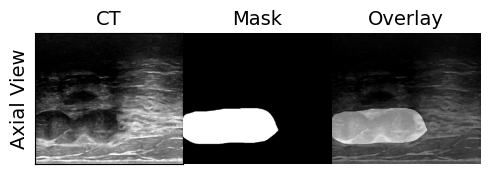

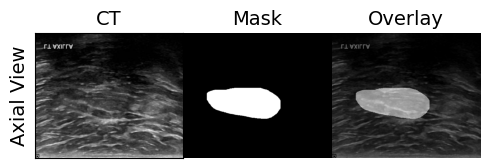

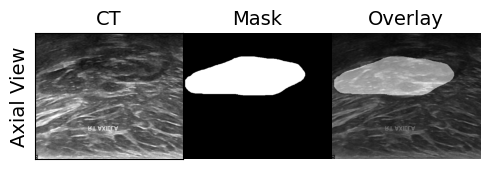

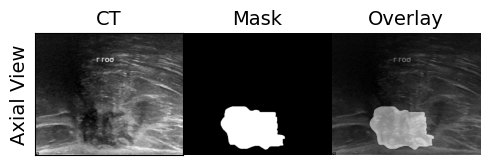

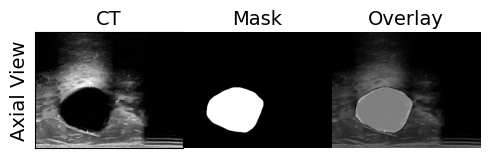

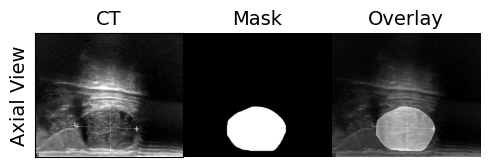

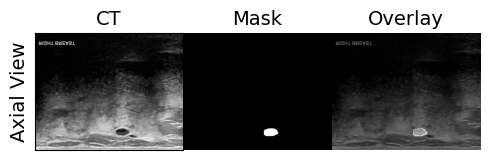

In [14]:
random_image = random.sample(range(750), 7)
for image in random_image:
    plot_train_label(series[image])

In [15]:
dataset = pd.DataFrame(series, columns=['image_path', 'mask_path'])

In [16]:
dataset

,image_path,mask_path
0,/media/mountHDD3/data_storage/biomedical_data/...,/media/mountHDD3/data_storage/biomedical_data/...
1,/media/mountHDD3/data_storage/biomedical_data/...,/media/mountHDD3/data_storage/biomedical_data/...
2,/media/mountHDD3/data_storage/biomedical_data/...,/media/mountHDD3/data_storage/biomedical_data/...
3,/media/mountHDD3/data_storage/biomedical_data/...,/media/mountHDD3/data_storage/biomedical_data/...
4,/media/mountHDD3/data_storage/biomedical_data/...,/media/mountHDD3/data_storage/biomedical_data/...
...,...,...
775,/media/mountHDD3/data_storage/biomedical_data/...,/media/mountHDD3/data_storage/biomedical_data/...
776,/media/mountHDD3/data_storage/biomedical_data/...,/media/mountHDD3/data_storage/biomedical_data/...
777,/media/mountHDD3/data_storage/biomedical_data/...,/media/mountHDD3/data_storage/biomedical_data/...
778,/media/mountHDD3/data_storage/biomedical_data/...,/media/mountHDD3/data_storage/biomedical_data/...


In [17]:
from sklearn.model_selection import train_test_split

train, testval = train_test_split(dataset, test_size=0.3, random_state=42)
test, val = train_test_split(testval, test_size=0.5, random_state=42)

In [18]:
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (546, 2)
Test shape: (117, 2)


In [19]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class CustomImageMaskDataset(Dataset):
    np.random.seed(42)
    torch.manual_seed(42)
    def __init__(self, dataframe, image_transform=None):
        self.data = dataframe
        self.image_transform = image_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx]['image_path']
        mask_path = self.data.iloc[idx]['mask_path']

        image = Image.open(image_path).convert('L') 
        mask = Image.open(mask_path).convert('L')

        if self.image_transform:
            image = self.image_transform(image)
            mask = self.image_transform(mask)

        return image, mask

# Define transformations with selected augmentation techniques and normalization for grayscale
image_size = 256
    
train_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),           # Resize to fixed size
    # transforms.RandomHorizontalFlip(),                      # Random horizontal flip
    # transforms.RandomVerticalFlip(),                        # Random vertical flip
    # transforms.RandomRotation(30),                          # Random rotation by up to 30 degrees
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Random color jitter
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random affine transformations (translation)
    transforms.ToTensor(),                                  # Convert images to tensor
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet mean/std
])


val_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),
    transforms.ToTensor(),
])


# Create datasets
train_dataset = CustomImageMaskDataset(train, train_transforms)
val_dataset = CustomImageMaskDataset(val, val_transforms)
test_dataset = CustomImageMaskDataset(test, val_transforms)

# Create DataLoaders
batch_size = 4
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [14]:
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# # Define Albumentations transformations for image and mask
# train_transform = A.Compose([
#     A.Resize(256, 256),  # Resize both image and mask
#     A.RandomRotate90(),
#     A.HorizontalFlip(),
#     A.VerticalFlip(),
#     A.RandomBrightnessContrast(),
#     ToTensorV2(),  # Convert both image and mask to PyTorch tensor
# ])

# # Define Albumentations transformations for validation and test (no augmentation)
# val_test_transform = A.Compose([
#     A.Resize(256, 256),  # Resize both image and mask
#     ToTensorV2(),  # Convert both image and mask to PyTorch tensor
# ])

# # Custom dataset class using Albumentations
# class CustomImageMaskDataset(Dataset):
#     np.random.seed(42)
#     torch.manual_seed(42)

#     def __init__(self, dataframe, transform=None):
#         self.data = dataframe
#         self.transform = transform

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         image_path = self.data.iloc[idx]['image_path']
#         mask_path = self.data.iloc[idx]['mask_path']

#         # Load images and masks
#         image = Image.open(image_path).convert('L')  # Convert to grayscale
#         mask = Image.open(mask_path).convert('L')    # Convert to grayscale

#         # Convert PIL images to numpy arrays for Albumentations
#         image = np.array(image)
#         mask = np.array(mask)

#         if self.transform:
#             # Apply the same transform to both image and mask
#             augmented = self.transform(image=image, mask=mask)
#             image = augmented['image']
#             mask = augmented['mask']

#         # Ensure mask has the same channel dimension as the image (1 channel)
#         mask = mask.unsqueeze(0)  # Add channel dimension to mask (1 channel)

#         return image, mask

# # Apply transformations and create datasets
# train_dataset = CustomImageMaskDataset(train, transform=train_transform)
# val_dataset = CustomImageMaskDataset(val, transform=val_test_transform)
# test_dataset = CustomImageMaskDataset(test, transform=val_test_transform)

# # DataLoader creation
# batch_size = 16
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [15]:
for batch in train_dataloader:
    # Assuming your dataset returns a tuple (inputs, targets)
    inputs, targets = batch
    
    # Print the shapes
    print("Input shape:", inputs.shape)
    print("Target shape:", targets.shape)
    break

Input shape: torch.Size([4, 1, 256, 256])
Target shape: torch.Size([4, 1, 256, 256])


In [16]:
# import matplotlib.pyplot as plt

# # Function to show images and masks
# def show_images(images, masks, n=5):
#     for i in range(n):
#         plt.subplot(2, n, i + 1)
#         plt.imshow(images[i].permute(1, 2, 0), cmap='gray')
#         plt.title(f'Image {i+1}')
#         plt.axis('off')

#         plt.subplot(2, n, i + 1 + n)
#         plt.imshow(masks[i], cmap='gray')  # No permute for masks
#         plt.title(f'Mask {i+1}')
#         plt.axis('off')
        
#     plt.show()

# # Show some images and their corresponding masks from the train_dataloader
# for batch_idx, (images, masks) in enumerate(train_dataloader):
#     # Convert to CPU if needed, as the data might be on GPU
#     images, masks = images.cpu(), masks.cpu()

#     # Show the first 5 images and masks
#     show_images(images, masks, n=5)
    
#     # Break after showing one batch of images
#     break


# Model

In [2]:
import time
import math
from functools import partial
from typing import Optional, Callable

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from einops import rearrange, repeat
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
try:
    from mamba_ssm.ops.selective_scan_interface import selective_scan_fn, selective_scan_ref
except:
    pass

# an alternative for mamba_ssm (in which causal_conv1d is needed)
try:
    from selective_scan import selective_scan_fn as selective_scan_fn_v1
    from selective_scan import selective_scan_ref as selective_scan_ref_v1
except:
    pass

DropPath.__repr__ = lambda self: f"timm.DropPath({self.drop_prob})"


def flops_selective_scan_ref(B=1, L=256, D=768, N=16, with_D=True, with_Z=False, with_Group=True, with_complex=False):
    """
    u: r(B D L)
    delta: r(B D L)
    A: r(D N)
    B: r(B N L)
    C: r(B N L)
    D: r(D)
    z: r(B D L)
    delta_bias: r(D), fp32
    
    ignores:
        [.float(), +, .softplus, .shape, new_zeros, repeat, stack, to(dtype), silu] 
    """
    import numpy as np
    
    # fvcore.nn.jit_handles
    def get_flops_einsum(input_shapes, equation):
        np_arrs = [np.zeros(s) for s in input_shapes]
        optim = np.einsum_path(equation, *np_arrs, optimize="optimal")[1]
        for line in optim.split("\n"):
            if "optimized flop" in line.lower():
                # divided by 2 because we count MAC (multiply-add counted as one flop)
                flop = float(np.floor(float(line.split(":")[-1]) / 2))
                return flop
    

    assert not with_complex

    flops = 0 # below code flops = 0
    if False:
        ...
        """
        dtype_in = u.dtype
        u = u.float()
        delta = delta.float()
        if delta_bias is not None:
            delta = delta + delta_bias[..., None].float()
        if delta_softplus:
            delta = F.softplus(delta)
        batch, dim, dstate = u.shape[0], A.shape[0], A.shape[1]
        is_variable_B = B.dim() >= 3
        is_variable_C = C.dim() >= 3
        if A.is_complex():
            if is_variable_B:
                B = torch.view_as_complex(rearrange(B.float(), "... (L two) -> ... L two", two=2))
            if is_variable_C:
                C = torch.view_as_complex(rearrange(C.float(), "... (L two) -> ... L two", two=2))
        else:
            B = B.float()
            C = C.float()
        x = A.new_zeros((batch, dim, dstate))
        ys = []
        """

    flops += get_flops_einsum([[B, D, L], [D, N]], "bdl,dn->bdln")
    if with_Group:
        flops += get_flops_einsum([[B, D, L], [B, N, L], [B, D, L]], "bdl,bnl,bdl->bdln")
    else:
        flops += get_flops_einsum([[B, D, L], [B, D, N, L], [B, D, L]], "bdl,bdnl,bdl->bdln")
    if False:
        ...
        """
        deltaA = torch.exp(torch.einsum('bdl,dn->bdln', delta, A))
        if not is_variable_B:
            deltaB_u = torch.einsum('bdl,dn,bdl->bdln', delta, B, u)
        else:
            if B.dim() == 3:
                deltaB_u = torch.einsum('bdl,bnl,bdl->bdln', delta, B, u)
            else:
                B = repeat(B, "B G N L -> B (G H) N L", H=dim // B.shape[1])
                deltaB_u = torch.einsum('bdl,bdnl,bdl->bdln', delta, B, u)
        if is_variable_C and C.dim() == 4:
            C = repeat(C, "B G N L -> B (G H) N L", H=dim // C.shape[1])
        last_state = None
        """
    
    in_for_flops = B * D * N   
    if with_Group:
        in_for_flops += get_flops_einsum([[B, D, N], [B, D, N]], "bdn,bdn->bd")
    else:
        in_for_flops += get_flops_einsum([[B, D, N], [B, N]], "bdn,bn->bd")
    flops += L * in_for_flops 
    if False:
        ...
        """
        for i in range(u.shape[2]):
            x = deltaA[:, :, i] * x + deltaB_u[:, :, i]
            if not is_variable_C:
                y = torch.einsum('bdn,dn->bd', x, C)
            else:
                if C.dim() == 3:
                    y = torch.einsum('bdn,bn->bd', x, C[:, :, i])
                else:
                    y = torch.einsum('bdn,bdn->bd', x, C[:, :, :, i])
            if i == u.shape[2] - 1:
                last_state = x
            if y.is_complex():
                y = y.real * 2
            ys.append(y)
        y = torch.stack(ys, dim=2) # (batch dim L)
        """

    if with_D:
        flops += B * D * L
    if with_Z:
        flops += B * D * L
    if False:
        ...
        """
        out = y if D is None else y + u * rearrange(D, "d -> d 1")
        if z is not None:
            out = out * F.silu(z)
        out = out.to(dtype=dtype_in)
        """
    
    return flops


class PatchEmbed2D(nn.Module):
    r""" Image to Patch Embedding
    Args:
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """
    def __init__(self, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None, **kwargs):
        super().__init__()
        if isinstance(patch_size, int):
            patch_size = (patch_size, patch_size)
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        x = self.proj(x).permute(0, 2, 3, 1)
        if self.norm is not None:
            x = self.norm(x)
        return x


class PatchMerging2D(nn.Module):
    r""" Patch Merging Layer.
    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        B, H, W, C = x.shape

        SHAPE_FIX = [-1, -1]
        if (W % 2 != 0) or (H % 2 != 0):
            print(f"Warning, x.shape {x.shape} is not match even ===========", flush=True)
            SHAPE_FIX[0] = H // 2
            SHAPE_FIX[1] = W // 2

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C

        if SHAPE_FIX[0] > 0:
            x0 = x0[:, :SHAPE_FIX[0], :SHAPE_FIX[1], :]
            x1 = x1[:, :SHAPE_FIX[0], :SHAPE_FIX[1], :]
            x2 = x2[:, :SHAPE_FIX[0], :SHAPE_FIX[1], :]
            x3 = x3[:, :SHAPE_FIX[0], :SHAPE_FIX[1], :]
        
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, H//2, W//2, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x
    

class PatchExpand2D(nn.Module):
    def __init__(self, dim, dim_scale=2, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim*2
        self.dim_scale = dim_scale
        self.expand = nn.Linear(self.dim, dim_scale*self.dim, bias=False)
        self.norm = norm_layer(self.dim // dim_scale)

    def forward(self, x):
        B, H, W, C = x.shape
        x = self.expand(x)

        x = rearrange(x, 'b h w (p1 p2 c)-> b (h p1) (w p2) c', p1=self.dim_scale, p2=self.dim_scale, c=C//self.dim_scale)
        x= self.norm(x)

        return x
    

class Final_PatchExpand2D(nn.Module):
    def __init__(self, dim, dim_scale=4, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.dim_scale = dim_scale
        self.expand = nn.Linear(self.dim, dim_scale*self.dim, bias=False)
        self.norm = norm_layer(self.dim // dim_scale)

    def forward(self, x):
        B, H, W, C = x.shape
        x = self.expand(x)

        x = rearrange(x, 'b h w (p1 p2 c)-> b (h p1) (w p2) c', p1=self.dim_scale, p2=self.dim_scale, c=C//self.dim_scale)
        x= self.norm(x)

        return x


class SS2D(nn.Module):
    def __init__(
        self,
        d_model,
        d_state=16,
        # d_state="auto", # 20240109
        d_conv=3,
        expand=2,
        dt_rank="auto",
        dt_min=0.001,
        dt_max=0.1,
        dt_init="random",
        dt_scale=1.0,
        dt_init_floor=1e-4,
        dropout=0.,
        conv_bias=True,
        bias=False,
        device=None,
        dtype=None,
        **kwargs,
    ):
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.d_model = d_model
        self.d_state = d_state
        # self.d_state = math.ceil(self.d_model / 6) if d_state == "auto" else d_model # 20240109
        self.d_conv = d_conv
        self.expand = expand
        self.d_inner = int(self.expand * self.d_model)
        self.dt_rank = math.ceil(self.d_model / 16) if dt_rank == "auto" else dt_rank

        self.in_proj = nn.Linear(self.d_model, self.d_inner * 2, bias=bias, **factory_kwargs)
        self.conv2d = nn.Conv2d(
            in_channels=self.d_inner,
            out_channels=self.d_inner,
            groups=self.d_inner,
            bias=conv_bias,
            kernel_size=d_conv,
            padding=(d_conv - 1) // 2,
            **factory_kwargs,
        )
        self.act = nn.SiLU()

        self.x_proj = (
            nn.Linear(self.d_inner, (self.dt_rank + self.d_state * 2), bias=False, **factory_kwargs), 
            nn.Linear(self.d_inner, (self.dt_rank + self.d_state * 2), bias=False, **factory_kwargs), 
            nn.Linear(self.d_inner, (self.dt_rank + self.d_state * 2), bias=False, **factory_kwargs), 
            nn.Linear(self.d_inner, (self.dt_rank + self.d_state * 2), bias=False, **factory_kwargs), 
        )
        self.x_proj_weight = nn.Parameter(torch.stack([t.weight for t in self.x_proj], dim=0)) # (K=4, N, inner)
        del self.x_proj

        self.dt_projs = (
            self.dt_init(self.dt_rank, self.d_inner, dt_scale, dt_init, dt_min, dt_max, dt_init_floor, **factory_kwargs),
            self.dt_init(self.dt_rank, self.d_inner, dt_scale, dt_init, dt_min, dt_max, dt_init_floor, **factory_kwargs),
            self.dt_init(self.dt_rank, self.d_inner, dt_scale, dt_init, dt_min, dt_max, dt_init_floor, **factory_kwargs),
            self.dt_init(self.dt_rank, self.d_inner, dt_scale, dt_init, dt_min, dt_max, dt_init_floor, **factory_kwargs),
        )
        self.dt_projs_weight = nn.Parameter(torch.stack([t.weight for t in self.dt_projs], dim=0)) # (K=4, inner, rank)
        self.dt_projs_bias = nn.Parameter(torch.stack([t.bias for t in self.dt_projs], dim=0)) # (K=4, inner)
        del self.dt_projs
        
        self.A_logs = self.A_log_init(self.d_state, self.d_inner, copies=4, merge=True) # (K=4, D, N)
        self.Ds = self.D_init(self.d_inner, copies=4, merge=True) # (K=4, D, N)

        # self.selective_scan = selective_scan_fn
        self.forward_core = self.forward_corev0

        self.out_norm = nn.LayerNorm(self.d_inner)
        self.out_proj = nn.Linear(self.d_inner, self.d_model, bias=bias, **factory_kwargs)
        self.dropout = nn.Dropout(dropout) if dropout > 0. else None

    @staticmethod
    def dt_init(dt_rank, d_inner, dt_scale=1.0, dt_init="random", dt_min=0.001, dt_max=0.1, dt_init_floor=1e-4, **factory_kwargs):
        dt_proj = nn.Linear(dt_rank, d_inner, bias=True, **factory_kwargs)

        # Initialize special dt projection to preserve variance at initialization
        dt_init_std = dt_rank**-0.5 * dt_scale
        if dt_init == "constant":
            nn.init.constant_(dt_proj.weight, dt_init_std)
        elif dt_init == "random":
            nn.init.uniform_(dt_proj.weight, -dt_init_std, dt_init_std)
        else:
            raise NotImplementedError

        # Initialize dt bias so that F.softplus(dt_bias) is between dt_min and dt_max
        dt = torch.exp(
            torch.rand(d_inner, **factory_kwargs) * (math.log(dt_max) - math.log(dt_min))
            + math.log(dt_min)
        ).clamp(min=dt_init_floor)
        # Inverse of softplus: https://github.com/pytorch/pytorch/issues/72759
        inv_dt = dt + torch.log(-torch.expm1(-dt))
        with torch.no_grad():
            dt_proj.bias.copy_(inv_dt)
        # Our initialization would set all Linear.bias to zero, need to mark this one as _no_reinit
        dt_proj.bias._no_reinit = True
        
        return dt_proj

    @staticmethod
    def A_log_init(d_state, d_inner, copies=1, device=None, merge=True):
        # S4D real initialization
        A = repeat(
            torch.arange(1, d_state + 1, dtype=torch.float32, device=device),
            "n -> d n",
            d=d_inner,
        ).contiguous()
        A_log = torch.log(A)  # Keep A_log in fp32
        if copies > 1:
            A_log = repeat(A_log, "d n -> r d n", r=copies)
            if merge:
                A_log = A_log.flatten(0, 1)
        A_log = nn.Parameter(A_log)
        A_log._no_weight_decay = True
        return A_log

    @staticmethod
    def D_init(d_inner, copies=1, device=None, merge=True):
        # D "skip" parameter
        D = torch.ones(d_inner, device=device)
        if copies > 1:
            D = repeat(D, "n1 -> r n1", r=copies)
            if merge:
                D = D.flatten(0, 1)
        D = nn.Parameter(D)  # Keep in fp32
        D._no_weight_decay = True
        return D

    def forward_corev0(self, x: torch.Tensor):
        self.selective_scan = selective_scan_fn
        
        B, C, H, W = x.shape
        L = H * W
        K = 4

        x_hwwh = torch.stack([x.view(B, -1, L), torch.transpose(x, dim0=2, dim1=3).contiguous().view(B, -1, L)], dim=1).view(B, 2, -1, L)
        xs = torch.cat([x_hwwh, torch.flip(x_hwwh, dims=[-1])], dim=1) # (b, k, d, l)

        x_dbl = torch.einsum("b k d l, k c d -> b k c l", xs.view(B, K, -1, L), self.x_proj_weight)
        # x_dbl = x_dbl + self.x_proj_bias.view(1, K, -1, 1)
        dts, Bs, Cs = torch.split(x_dbl, [self.dt_rank, self.d_state, self.d_state], dim=2)
        dts = torch.einsum("b k r l, k d r -> b k d l", dts.view(B, K, -1, L), self.dt_projs_weight)
        # dts = dts + self.dt_projs_bias.view(1, K, -1, 1)

        xs = xs.float().view(B, -1, L) # (b, k * d, l)
        dts = dts.contiguous().float().view(B, -1, L) # (b, k * d, l)
        Bs = Bs.float().view(B, K, -1, L) # (b, k, d_state, l)
        Cs = Cs.float().view(B, K, -1, L) # (b, k, d_state, l)
        Ds = self.Ds.float().view(-1) # (k * d)
        As = -torch.exp(self.A_logs.float()).view(-1, self.d_state)  # (k * d, d_state)
        dt_projs_bias = self.dt_projs_bias.float().view(-1) # (k * d)

        out_y = self.selective_scan(
            xs, dts, 
            As, Bs, Cs, Ds, z=None,
            delta_bias=dt_projs_bias,
            delta_softplus=True,
            return_last_state=False,
        ).view(B, K, -1, L)
        assert out_y.dtype == torch.float

        inv_y = torch.flip(out_y[:, 2:4], dims=[-1]).view(B, 2, -1, L)
        wh_y = torch.transpose(out_y[:, 1].view(B, -1, W, H), dim0=2, dim1=3).contiguous().view(B, -1, L)
        invwh_y = torch.transpose(inv_y[:, 1].view(B, -1, W, H), dim0=2, dim1=3).contiguous().view(B, -1, L)

        return out_y[:, 0], inv_y[:, 0], wh_y, invwh_y

    # an alternative to forward_corev1
    def forward_corev1(self, x: torch.Tensor):
        self.selective_scan = selective_scan_fn_v1

        B, C, H, W = x.shape
        L = H * W
        K = 4

        x_hwwh = torch.stack([x.view(B, -1, L), torch.transpose(x, dim0=2, dim1=3).contiguous().view(B, -1, L)], dim=1).view(B, 2, -1, L)
        xs = torch.cat([x_hwwh, torch.flip(x_hwwh, dims=[-1])], dim=1) # (b, k, d, l)

        x_dbl = torch.einsum("b k d l, k c d -> b k c l", xs.view(B, K, -1, L), self.x_proj_weight)
        # x_dbl = x_dbl + self.x_proj_bias.view(1, K, -1, 1)
        dts, Bs, Cs = torch.split(x_dbl, [self.dt_rank, self.d_state, self.d_state], dim=2)
        dts = torch.einsum("b k r l, k d r -> b k d l", dts.view(B, K, -1, L), self.dt_projs_weight)
        # dts = dts + self.dt_projs_bias.view(1, K, -1, 1)

        xs = xs.float().view(B, -1, L) # (b, k * d, l)
        dts = dts.contiguous().float().view(B, -1, L) # (b, k * d, l)
        Bs = Bs.float().view(B, K, -1, L) # (b, k, d_state, l)
        Cs = Cs.float().view(B, K, -1, L) # (b, k, d_state, l)
        Ds = self.Ds.float().view(-1) # (k * d)
        As = -torch.exp(self.A_logs.float()).view(-1, self.d_state)  # (k * d, d_state)
        dt_projs_bias = self.dt_projs_bias.float().view(-1) # (k * d)

        out_y = self.selective_scan(
            xs, dts, 
            As, Bs, Cs, Ds,
            delta_bias=dt_projs_bias,
            delta_softplus=True,
        ).view(B, K, -1, L)
        assert out_y.dtype == torch.float

        inv_y = torch.flip(out_y[:, 2:4], dims=[-1]).view(B, 2, -1, L)
        wh_y = torch.transpose(out_y[:, 1].view(B, -1, W, H), dim0=2, dim1=3).contiguous().view(B, -1, L)
        invwh_y = torch.transpose(inv_y[:, 1].view(B, -1, W, H), dim0=2, dim1=3).contiguous().view(B, -1, L)

        return out_y[:, 0], inv_y[:, 0], wh_y, invwh_y

    def forward(self, x: torch.Tensor, **kwargs):
        B, H, W, C = x.shape

        xz = self.in_proj(x)
        x, z = xz.chunk(2, dim=-1) # (b, h, w, d)

        x = x.permute(0, 3, 1, 2).contiguous()
        x = self.act(self.conv2d(x)) # (b, d, h, w)
        y1, y2, y3, y4 = self.forward_core(x)
        assert y1.dtype == torch.float32
        y = y1 + y2 + y3 + y4
        y = torch.transpose(y, dim0=1, dim1=2).contiguous().view(B, H, W, -1)
        y = self.out_norm(y)
        y = y * F.silu(z)
        out = self.out_proj(y)
        if self.dropout is not None:
            out = self.dropout(out)
        return out


class VSSBlock(nn.Module):
    def __init__(
        self,
        hidden_dim: int = 0,
        drop_path: float = 0,
        norm_layer: Callable[..., torch.nn.Module] = partial(nn.LayerNorm, eps=1e-6),
        attn_drop_rate: float = 0,
        d_state: int = 16,
        **kwargs,
    ):
        super().__init__()
        self.ln_1 = norm_layer(hidden_dim)
        self.self_attention = SS2D(d_model=hidden_dim, dropout=attn_drop_rate, d_state=d_state, **kwargs)
        self.drop_path = DropPath(drop_path)

    def forward(self, input: torch.Tensor):
        x = input + self.drop_path(self.self_attention(self.ln_1(input)))
        return x


class VSSLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.
    Args:
        dim (int): Number of input channels.
        depth (int): Number of blocks.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(
        self, 
        dim, 
        depth, 
        attn_drop=0.,
        drop_path=0., 
        norm_layer=nn.LayerNorm, 
        downsample=None, 
        use_checkpoint=False, 
        d_state=16,
        **kwargs,
    ):
        super().__init__()
        self.dim = dim
        self.use_checkpoint = use_checkpoint

        self.blocks = nn.ModuleList([
            VSSBlock(
                hidden_dim=dim,
                drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                norm_layer=norm_layer,
                attn_drop_rate=attn_drop,
                d_state=d_state,
            )
            for i in range(depth)])
        
        if True: # is this really applied? Yes, but been overriden later in VSSM!
            def _init_weights(module: nn.Module):
                for name, p in module.named_parameters():
                    if name in ["out_proj.weight"]:
                        p = p.clone().detach_() # fake init, just to keep the seed ....
                        nn.init.kaiming_uniform_(p, a=math.sqrt(5))
            self.apply(_init_weights)

        if downsample is not None:
            self.downsample = downsample(dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None


    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        
        if self.downsample is not None:
            x = self.downsample(x)

        return x
    


class VSSLayer_up(nn.Module):
    """ A basic Swin Transformer layer for one stage.
    Args:
        dim (int): Number of input channels.
        depth (int): Number of blocks.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(
        self, 
        dim, 
        depth, 
        attn_drop=0.,
        drop_path=0., 
        norm_layer=nn.LayerNorm, 
        upsample=None, 
        use_checkpoint=False, 
        d_state=16,
        **kwargs,
    ):
        super().__init__()
        self.dim = dim
        self.use_checkpoint = use_checkpoint

        self.blocks = nn.ModuleList([
            VSSBlock(
                hidden_dim=dim,
                drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                norm_layer=norm_layer,
                attn_drop_rate=attn_drop,
                d_state=d_state,
            )
            for i in range(depth)])
        
        if True: # is this really applied? Yes, but been overriden later in VSSM!
            def _init_weights(module: nn.Module):
                for name, p in module.named_parameters():
                    if name in ["out_proj.weight"]:
                        p = p.clone().detach_() # fake init, just to keep the seed ....
                        nn.init.kaiming_uniform_(p, a=math.sqrt(5))
            self.apply(_init_weights)

        if upsample is not None:
            self.upsample = upsample(dim=dim, norm_layer=norm_layer)
        else:
            self.upsample = None


    def forward(self, x):
        if self.upsample is not None:
            x = self.upsample(x)
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        return x
    


class VSSM(nn.Module):
    def __init__(self, patch_size=4, in_chans=3, num_classes=1000, depths=[2, 2, 9, 2], depths_decoder=[2, 9, 2, 2],
                 dims=[96, 192, 384, 768], dims_decoder=[768, 384, 192, 96], d_state=16, drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, patch_norm=True,
                 use_checkpoint=False, **kwargs):
        super().__init__()
        self.num_classes = num_classes
        self.num_layers = len(depths)
        if isinstance(dims, int):
            dims = [int(dims * 2 ** i_layer) for i_layer in range(self.num_layers)]
        self.embed_dim = dims[0]
        self.num_features = dims[-1]
        self.dims = dims

        self.patch_embed = PatchEmbed2D(patch_size=patch_size, in_chans=in_chans, embed_dim=self.embed_dim,
            norm_layer=norm_layer if patch_norm else None)

        # WASTED absolute position embedding ======================
        self.ape = False
        # self.ape = False
        # drop_rate = 0.0
        if self.ape:
            self.patches_resolution = self.patch_embed.patches_resolution
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, *self.patches_resolution, self.embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule
        dpr_decoder = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths_decoder))][::-1]

        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = VSSLayer(
                dim=dims[i_layer],
                depth=depths[i_layer],
                d_state=math.ceil(dims[0] / 6) if d_state is None else d_state, # 20240109
                drop=drop_rate, 
                attn_drop=attn_drop_rate,
                drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                norm_layer=norm_layer,
                downsample=PatchMerging2D if (i_layer < self.num_layers - 1) else None,
                use_checkpoint=use_checkpoint,
            )
            self.layers.append(layer)

        self.layers_up = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = VSSLayer_up(
                dim=dims_decoder[i_layer],
                depth=depths_decoder[i_layer],
                d_state=math.ceil(dims[0] / 6) if d_state is None else d_state, # 20240109
                drop=drop_rate, 
                attn_drop=attn_drop_rate,
                drop_path=dpr_decoder[sum(depths_decoder[:i_layer]):sum(depths_decoder[:i_layer + 1])],
                norm_layer=norm_layer,
                upsample=PatchExpand2D if (i_layer != 0) else None,
                use_checkpoint=use_checkpoint,
            )
            self.layers_up.append(layer)

        self.final_up = Final_PatchExpand2D(dim=dims_decoder[-1], dim_scale=4, norm_layer=norm_layer)
        self.final_conv = nn.Conv2d(dims_decoder[-1]//4, num_classes, 1)

        # self.norm = norm_layer(self.num_features)
        # self.avgpool = nn.AdaptiveAvgPool1d(1)
        # self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m: nn.Module):
        """
        out_proj.weight which is previously initilized in VSSBlock, would be cleared in nn.Linear
        no fc.weight found in the any of the model parameters
        no nn.Embedding found in the any of the model parameters
        so the thing is, VSSBlock initialization is useless
        
        Conv2D is not intialized !!!
        """
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def forward_features(self, x):
        skip_list = []
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            skip_list.append(x)
            x = layer(x)
        return x, skip_list
    
    def forward_features_up(self, x, skip_list):
        for inx, layer_up in enumerate(self.layers_up):
            if inx == 0:
                x = layer_up(x)
            else:
                x = layer_up(x+skip_list[-inx])

        return x
    
    def forward_final(self, x):
        x = self.final_up(x)
        x = x.permute(0,3,1,2)
        x = self.final_conv(x)
        return x

    def forward_backbone(self, x):
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x)
        return x

    def forward(self, x):
        x, skip_list = self.forward_features(x)
        x = self.forward_features_up(x, skip_list)
        x = self.forward_final(x)
        
        return x




    


import torch
from torch import nn


class VMUNet(nn.Module):
    def __init__(self, 
                 input_channels=3, 
                 num_classes=1,
                 depths=[2, 2, 9, 2], 
                 depths_decoder=[2, 9, 2, 2],
                 drop_path_rate=0.2,
                 load_ckpt_path=None,
                ):
        super().__init__()

        self.load_ckpt_path = load_ckpt_path
        self.num_classes = num_classes

        self.vmunet = VSSM(in_chans=input_channels,
                           num_classes=num_classes,
                           depths=depths,
                           depths_decoder=depths_decoder,
                           drop_path_rate=drop_path_rate,
                        )
    
    def forward(self, x):
        if x.size()[1] == 1:
            x = x.repeat(1,3,1,1)
        logits = self.vmunet(x)
        if self.num_classes == 1: return torch.sigmoid(logits)
        else: return logits
    
    def load_from(self):
        if self.load_ckpt_path is not None:
            model_dict = self.vmunet.state_dict()
            modelCheckpoint = torch.load(self.load_ckpt_path)
            pretrained_dict = modelCheckpoint['model']
            # 过滤操作
            new_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict.keys()}
            model_dict.update(new_dict)
            # 打印出来，更新了多少的参数
            print('Total model_dict: {}, Total pretrained_dict: {}, update: {}'.format(len(model_dict), len(pretrained_dict), len(new_dict)))
            self.vmunet.load_state_dict(model_dict)

            not_loaded_keys = [k for k in pretrained_dict.keys() if k not in new_dict.keys()]
            print('Not loaded keys:', not_loaded_keys)
            print("encoder loaded finished!")

            model_dict = self.vmunet.state_dict()
            modelCheckpoint = torch.load(self.load_ckpt_path)
            pretrained_odict = modelCheckpoint['model']
            pretrained_dict = {}
            for k, v in pretrained_odict.items():
                if 'layers.0' in k: 
                    new_k = k.replace('layers.0', 'layers_up.3')
                    pretrained_dict[new_k] = v
                elif 'layers.1' in k: 
                    new_k = k.replace('layers.1', 'layers_up.2')
                    pretrained_dict[new_k] = v
                elif 'layers.2' in k: 
                    new_k = k.replace('layers.2', 'layers_up.1')
                    pretrained_dict[new_k] = v
                elif 'layers.3' in k: 
                    new_k = k.replace('layers.3', 'layers_up.0')
                    pretrained_dict[new_k] = v
            # 过滤操作
            new_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict.keys()}
            model_dict.update(new_dict)
            # 打印出来，更新了多少的参数
            print('Total model_dict: {}, Total pretrained_dict: {}, update: {}'.format(len(model_dict), len(pretrained_dict), len(new_dict)))
            self.vmunet.load_state_dict(model_dict)
            
            # 找到没有加载的键(keys)
            not_loaded_keys = [k for k in pretrained_dict.keys() if k not in new_dict.keys()]
            print('Not loaded keys:', not_loaded_keys)
            print("decoder loaded finished!")

/media/mountHDD2/chuyenmt/.env/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [18]:
import torch
import os

# Đặt GPU cụ thể (GPU 1 trong trường hợp này)
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Kiểm tra xem CUDA có sẵn không và chọn thiết bị
if __name__ == '__main__':
    # Kiểm tra GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Khởi tạo model và chuyển lên GPU nếu có
    # Giả sử VMUNet được định nghĩa ở đâu đó.
    # Nếu không, bạn cần import nó hoặc định nghĩa nó ở đây.
    try:
        from your_module import VMUNet  # Thay 'your_module' bằng tên module của bạn
        model = VMUNet(input_channels=3, num_classes=1).to(device)
    except ImportError:
        print("Error: Could not import VMUNet.  Please make sure your module is correctly imported.")
        exit()  # Dừng chương trình nếu không tìm thấy VMUNet

    # Tạo tensor đầu vào và chuyển lên GPU
    input_tensor = torch.randn(1, 3, 256, 256).to(device)

    # Chạy model
    output = model(input_tensor)
    print(f"Output Shape: {output.shape}")

Using device: cuda
Error: Could not import VMUNet.  Please make sure your module is correctly imported.


NameError: name 'model' is not defined

In [4]:
class Trainer:
    def __init__(self, model, num_epochs, optimizer, criterion, device):
        self.num_epochs = num_epochs
        self.optimizer = optimizer
        self.criterion = criterion
        self.model = model
        self.device = device
        self.log_interval = 15

        # Lists to store training and validation metrics
        self.train_losses = []
        self.val_losses = []
        self.train_dices = []
        self.val_dices = []
        self.train_ious = []  # List to store training IoU
        self.val_ious = []    # List to store validation IoU

        # Best model and its metrics
        self.best_model = None
        self.best_dice = 0.0
        self.best_epoch = 0

    def dice_coeff(self, predicted, target, smooth=1e-5):
        intersection = torch.sum(predicted * target)
        union = torch.sum(predicted) + torch.sum(target)
        dice = (2. * intersection + smooth) / (union + smooth)
        return dice

    def iou(self, pred_mask, true_mask):
        intersection = torch.logical_and(pred_mask, true_mask).sum().item()
        union = torch.logical_or(pred_mask, true_mask).sum().item()
        iou_score = intersection / union if union != 0 else 0.0
        return iou_score
    def precision(self, outputs, targets, threshold=0.5):
        # Apply thresholding
        pred = (outputs > threshold).float()
        true_positives = (pred * targets).sum().item()
        predicted_positives = pred.sum().item()
        precision = true_positives / (predicted_positives + 1e-5)  # Add small epsilon to avoid division by zero
        return precision

    def recall(self, outputs, targets, threshold=0.5):
        # Apply thresholding
        pred = (outputs > threshold).float()
        true_positives = (pred * targets).sum().item()
        actual_positives = targets.sum().item()
        recall = true_positives / (actual_positives + 1e-5)  # Add small epsilon to avoid division by zero
        return recall

    def f1_score(self, precision, recall):
        if precision + recall == 0:
            return 0.0
        return 2 * (precision * recall) / (precision + recall)
    def save_best_model(self, epoch, dice):
        if dice > self.best_dice:
            self.best_dice = dice
            self.best_epoch = epoch
            self.best_model = self.model.state_dict()

            filename = f'best_model_epoch{epoch}_dice{dice:.4f}.pth'
            torch.save(self.model, filename)  # Save entire model (including architecture and weights)

    def train(self, train_loader, val_loader, test_loader=None):
        for epoch in range(self.num_epochs):
            train_loss = 0.0
            val_loss = 0.0
            train_dice = 0.0
            val_dice = 0.0
            train_iou = 0.0  # Initialize training IoU
            val_iou = 0.0    # Initialize validation IoU

            # Training loop
            for i, (images, masks) in enumerate(train_loader):
                images, masks = images.to(self.device), masks.to(self.device)

                self.model.train()
                self.optimizer.zero_grad()

                outputs = self.model(images)
                loss = self.criterion(outputs, masks)
                dice = self.dice_coeff(outputs, masks)
                iou = self.iou(outputs > 0.5, masks)  # Calculate IoU

                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                train_dice += dice
                train_iou += iou  # Accumulate IoU

                if (i + 1) % self.log_interval == 0:
                    print(f'Epoch [{epoch + 1}/{self.num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}, Dice: {dice:.4f}, IoU: {iou:.4f}')

            # Validation loop
            self.model.eval()
            with torch.no_grad():
                for images, masks in val_loader:
                    images, masks = images.to(self.device), masks.to(self.device)
                    outputs = self.model(images)
                    val_loss += self.criterion(outputs, masks).item()
                    val_dice += self.dice_coeff(outputs, masks)
                    val_iou += self.iou(outputs > 0.5, masks)  # Calculate IoU for validation

            avg_train_loss = train_loss / len(train_loader)
            avg_val_loss = val_loss / len(val_loader)
            avg_train_dice = train_dice / len(train_loader)
            avg_val_dice = val_dice / len(val_loader)
            avg_train_iou = train_iou / len(train_loader)  # Average IoU for training
            avg_val_iou = val_iou / len(val_loader)        # Average IoU for validation

            print(f'Epoch [{epoch + 1}/{self.num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
            print(f'Epoch [{epoch + 1}/{self.num_epochs}], Train Dice: {avg_train_dice:.4f}, Val Dice: {avg_val_dice:.4f}')
            print(f'Epoch [{epoch + 1}/{self.num_epochs}], Train IoU: {avg_train_iou:.4f}, Val IoU: {avg_val_iou:.4f}')

            # Save metrics
            self.train_losses.append(avg_train_loss)
            self.val_losses.append(avg_val_loss)
            self.train_dices.append(avg_train_dice)
            self.val_dices.append(avg_val_dice)
            self.train_ious.append(avg_train_iou)  # Save average training IoU
            self.val_ious.append(avg_val_iou)      # Save average validation IoU

            # Save best model
            # self.save_best_model(epoch + 1, avg_val_dice)

        # After training is finished, perform testing (if test_loader is provided)
        if test_loader:
            self.test(test_loader)

        # Save the final model after training
        self.save_final_model()

    def test(self, test_loader):
        self.model.eval()
        test_loss = 0.0
        test_dice = 0.0
        test_precision = 0.0
        test_recall = 0.0
        test_f1 = 0.0
        test_iou = 0.0
        with torch.no_grad():
            for images, masks in test_loader:
                images, masks = images.to(self.device), masks.to(self.device)
                outputs = self.model(images)
                loss = self.criterion(outputs, masks)
                dice = self.dice_coeff(outputs, masks)
                precision = self.precision(outputs, masks)
                recall = self.recall(outputs, masks)
                f1 = self.f1_score(precision, recall)
                iou = self.iou(outputs > 0.5, masks)

                test_loss += loss.item()
                test_dice += dice
                test_precision += precision
                test_recall += recall
                test_f1 += f1
                test_iou += iou

        avg_test_loss = test_loss / len(test_loader)
        avg_test_dice = test_dice / len(test_loader)
        avg_test_precision = test_precision / len(test_loader)
        avg_test_recall = test_recall / len(test_loader)
        avg_test_f1 = test_f1 / len(test_loader)
        avg_test_iou = test_iou / len(test_loader)

        print(f'Test Loss: {avg_test_loss:.4f}, Test Dice: {avg_test_dice:.4f}, Test Precision: {avg_test_precision:.4f}, Test Recall: {avg_test_recall:.4f}, Test F1-Score: {avg_test_f1:.4f}, Test IoU: {avg_test_iou:.4f}')

    def save_final_model(self):
        """Save the final model (both structure and weights) after training"""
        torch.save(self.model, 'weight/ViMUnet_original.pth')
        print("Final model saved as 'ViMU_model.pth'")

    def get_metrics(self):
        return {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'train_dices': self.train_dices,
            'val_dices': self.val_dices,
            'train_ious': self.train_ious,  # Include train IoUs
            'val_ious': self.val_ious,      # Include val IoUs
            'best_model': self.best_model,
            'best_dice': self.best_dice,
            'best_epoch': self.best_epoch
        }
def dice_coef_loss(inputs, target):
    smooth = 1e-6
    intersection = 2.0 * (target*inputs).sum() + smooth
    union = target.sum() + inputs.sum() + smooth
    return 1 - (intersection/union)

def bce_dice_loss(inputs, target):
    dice_score = dice_coef_loss(inputs, target)
    bce_loss = nn.BCELoss()
    bce_score = bce_loss(inputs, target)
    
    return bce_score + dice_score

In [ ]:
import time
start_time = time.time()

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VMUNet(input_channels=3, num_classes=1, depths=[2, 2, 2, 2], depths_decoder=[2, 2, 2, 2],).to(device)
learning_rate = 0.0001
weight_decay = 1e-6  # Regularization term to prevent overfitting

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

trainer = Trainer(model=model, num_epochs=100, optimizer=optimizer, criterion=bce_dice_loss, device=device)
trainer.train(train_dataloader, val_dataloader)
metrics = trainer.get_metrics()

 
end_time = time.time()
diff_time = (end_time - start_time) * 1000
print(diff_time)

In [ ]:
import time
start_time = time.time()
trainer.test(test_dataloader)
end_time = time.time()
diff_time = (end_time - start_time) * 1000
print(diff_time)

In [ ]:
trainer.test(val_dataloader)

In [ ]:
def to_numpy(value):
    # Check if the value is a tensor
    if isinstance(value, torch.Tensor):
        return value.cpu().detach().item()  # Convert tensor to scalar
    return value  # Return the value if it is already a scalar (float)


def plot_metrics(metrics):
    num_epochs = len(metrics['train_losses'])
    epochs = np.arange(1, num_epochs + 1)

    # Convert tensors to NumPy arrays
    train_losses_np = metrics['train_losses']
    val_losses_np = metrics['val_losses']
    train_dices_np = [to_numpy(dice) for dice in metrics['train_dices']]
    val_dices_np = [to_numpy(dice) for dice in metrics['val_dices']]
    train_ious_np = [to_numpy(iou) for iou in metrics['train_ious']]  # IoU for training
    val_ious_np = [to_numpy(iou) for iou in metrics['val_ious']]  # IoU for validation

    # Plot Losses
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses_np, label='Train Loss')
    plt.plot(epochs, val_losses_np, label='Val Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Dice Coefficients
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_dices_np, label='Train Dice')
    plt.plot(epochs, val_dices_np, label='Val Dice')
    plt.title('Training and Validation Dice Coefficients')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.legend()

    # Plot IoU (Intersection over Union)
    plt.subplot(2, 2, 3)
    plt.plot(epochs, train_ious_np, label='Train IoU')
    plt.plot(epochs, val_ious_np, label='Val IoU')
    plt.title('Training and Validation IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(metrics)


In [22]:
import matplotlib.pyplot as plt
import numpy as np

def to_numpy(tensor):
    # Move tensor to CPU and convert to NumPy array
    return tensor.cpu().detach().numpy()

def threshold_prediction(predicted, threshold=0.5):
    # Threshold predicted values
    predicted[predicted < threshold] = 0
    predicted[predicted >= threshold] = 1
    return predicted

def plot_subplots(image, mask, predicted, threshold=0.5):
    # Convert tensors to NumPy arrays
    image_np, mask_np, predicted_np = map(to_numpy, (image, mask, predicted))

    # Threshold the predicted values
    predicted_np_thresholded = threshold_prediction(predicted_np, threshold)

    fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # Adjust figsize as needed

    # Plot Image, Mask, Predicted, and Thresholded Predicted
    titles = ['Image', 'Mask', 'Predicted']
    for ax, data, title in zip(axes, [image_np, mask_np, predicted_np, predicted_np_thresholded], titles):
        ax.imshow(data.squeeze(), cmap='gray' if 'Mask' in title else 'gray')
        ax.set_title(title)
        ax.axis('off')

    plt.show()

In [27]:
for i in [2, 3, 11, 20, 55, 67, 87, 98, 120, 130, 200]:
    image = train_dataset[i][0]
    mask = train_dataset[i][1]
    im = image.to(device)
    pred = unet(im.unsqueeze(0))
    pred = pred.squeeze()

    plot_subplots(im, mask, pred)

NameError: name 'unet' is not defined

In [ ]:
for i in range(50):
    image = test_dataset[i][0]
    mask = test_dataset[i][1]
    im = image.to(device)
    pred = unet(im.unsqueeze(0))
    pred = pred.squeeze()

    plot_subplots(im, mask, pred)

# Test

In [ ]:
 
import torch
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
unet = VMUNet().to(device)
learning_rate = 0.0001
weight_decay = 1e-6  # Regularization term to prevent overfitting

optimizer = optim.Adam(unet.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Đường dẫn tới file model đã lưu
model_path = '/media/mountHDD2/chuyenmt/BrEaST/Breast_cancer_image_segmentation/notebook/weight/inception-ViM-Unet-in-VSS-block.pth'

# Load toàn bộ model (cấu trúc và trọng số)
model = torch.load(model_path)

# Đưa model về chế độ inference (để không cập nhật trọng số trong quá trình test)
model.eval()


trainer = Trainer(model=model, num_epochs=100, optimizer=optimizer, criterion=bce_dice_loss, device=device)
trainer.test(test_dataloader)

In [ ]:
from torch.utils.data import Dataset 
from PIL import Image
import torch
import glob
import albumentations as A
import cv2
import numpy as np
from torchvision import transforms
root = '/media/mountHDD3/data_storage/biomedical_data/Dataset/BrEaST/BrEaST-Lesions_USG-images_and_masks-Dec-15-2023/BrEaST-Lesions_USG-images_and_masks'
class Breast(Dataset):
    def __init__(self, root, transform=None, target_transform=None):
        self.msks = glob.glob(root + '/*_tumor.png')
        normal = [
            '/media/mountHDD3/data_storage/biomedical_data/Dataset/BrEaST/BrEaST-Lesions_USG-images_and_masks-Dec-15-2023/BrEaST-Lesions_USG-images_and_masks/case045.png',
            '/media/mountHDD3/data_storage/biomedical_data/Dataset/BrEaST/BrEaST-Lesions_USG-images_and_masks-Dec-15-2023/BrEaST-Lesions_USG-images_and_masks/case061.png',
            '/media/mountHDD3/data_storage/biomedical_data/Dataset/BrEaST/BrEaST-Lesions_USG-images_and_masks-Dec-15-2023/BrEaST-Lesions_USG-images_and_masks/case209.png',
            '/media/mountHDD3/data_storage/biomedical_data/Dataset/BrEaST/BrEaST-Lesions_USG-images_and_masks-Dec-15-2023/BrEaST-Lesions_USG-images_and_masks/case213.png',
        ]
        du = glob.glob(root+ '/*other*.png')
        self.imgs = [path for path in glob.glob(root+ '/*') if path not in (self.msks+du+normal)]


        # Ensure that the number of images and masks match
        assert len(self.imgs) == len(self.msks), "Number of images and masks don't match" 
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        msk_path = self.msks[idx]

        img = Image.open(img_path)
        msk = Image.open(msk_path)

        # Remove the 4th channel (if present)
        img = img.convert('RGB') if img.mode == 'RGBA' else img
        msk = msk.convert('L')  # Convert mask to grayscale (optional)

        if self.transform:
            img = self.transform(img)

        if self.target_transform:
            msk = self.target_transform(msk)

        return (img, msk)

transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),

    ]
)

target_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]
)

Data_transfered = Breast(root =root,transform = transform, target_transform=target_transform)
print(len(Data_transfered))

test_loader_2 = DataLoader(Data_transfered, batch_size=4, shuffle=True)

In [ ]:
trainer.test(test_loader_2)

In [ ]:
start_time = time.time()
trainer.test(test_loader_2)
end_time = time.time()
diff_time = (end_time - start_time) * 1000
print(diff_time)

In [ ]:
train, testt = train_test_split(Data_transfered, test_size=0.3, random_state=42)
test_loader_3 = DataLoader(testt, batch_size=4, shuffle=True)
trainer.test(test_loader_3)


In [19]:
import torch
import numpy as np
from torch.utils.data import DataLoader

# Khởi tạo mô hình  # Thay bằng mô hình của bạn
model = VMUNet(input_channels=3, num_classes=1).to(device)
model = torch.load('weight/final_model_ViM-Unet-100-epochs.pth')
model.eval()  # Chuyển sang chế độ đánh giá
model.to(device)

def dice_coeff(predicted, target, smooth=1e-5):
    intersection = torch.sum(predicted * target)
    union = torch.sum(predicted) + torch.sum(target)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def iou(predicted, target, threshold=0.5):
    predicted = (predicted > threshold).float() # Chuyển đổi outputs thành binary masks
    intersection = torch.logical_and(predicted, target).sum().item()
    union = torch.logical_or(predicted, target).sum().item()
    iou_score = intersection / union if union != 0 else 0.0
    return iou_score 

In [ ]:
 
def dice_coeff(predicted, target, smooth=1e-5):
    intersection = torch.sum(predicted * target)
    union = torch.sum(predicted) + torch.sum(target)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def iou(predicted, target, threshold=0.5):
    predicted = (predicted > threshold).float() # Chuyển đổi outputs thành binary masks
    intersection = torch.logical_and(predicted, target).sum().item()
    union = torch.logical_or(predicted, target).sum().item()
    iou_score = intersection / union if union != 0 else 0.0
    return iou_score 
# Tính Dice Scores và IoUs
results = []
dice_scores = []
iou_scores = []
with torch.no_grad():
    for i, (images, masks) in enumerate(val_dataloader):
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)

        # Tính Dice Score
        dice = dice_coeff(outputs, masks)
        dice_scores.append(dice.item())

        # Tính IoU
        iou_value = iou(outputs, masks)
        iou_scores.append(iou_value)

        # Lưu ID ảnh và kết quả
        results.append({"image_id": i, "dice_score": dice, "iou_score": iou_value})

# Chuyển đổi thành NumPy arrays
dice_scores = np.array(dice_scores)
iou_scores = np.array(iou_scores)

# In ra các thống kê mô tả
print("Mean Dice Score:", np.mean(dice_scores))
print("Standard Deviation (Dice):", np.std(dice_scores))
print("Mean IoU:", np.mean(iou_scores))
print("Standard Deviation (IoU):", np.std(iou_scores))


# Lưu vào CSV
df = pd.DataFrame(results)
df.to_csv("performance_ORIGINAL.csv", index=False)

print("Lưu kết quả vào model_results.csv thành công!")


In [27]:
series[1][1]

'/media/mountHDD3/data_storage/biomedical_data/Dataset/BUSI/Dataset_BUSI_with_GT/benign/benign (27)_mask.png'

In [29]:
series[1][0]

'/media/mountHDD3/data_storage/biomedical_data/Dataset/BUSI/Dataset_BUSI_with_GT/benign/benign (27).png'

In [38]:
image_path = series[3][0]
mask_path = series[3][1]

In [5]:
import torch
import numpy as np
from torch.utils.data import DataLoader
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# Khởi tạo mô hình  # Thay bằng mô hình của bạn
model = VMUNet(input_channels=3, num_classes=1).to(device)
model = torch.load('weight/final_model_ViM-Unet-100-epochs.pth')
model.eval()  # Chuyển sang chế độ đánh giá
model.to(device)

/tmp/ipykernel_2929619/4185518475.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('weight/final_model_ViM-Unet-100-epochs.pth')


VMUNet(
  (vmunet): VSSM(
    (patch_embed): PatchEmbed2D(
      (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): VSSLayer(
        (blocks): ModuleList(
          (0): VSSBlock(
            (ln_1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (self_attention): SS2D(
              (in_proj): Linear(in_features=96, out_features=384, bias=False)
              (conv2d): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=192)
              (act): SiLU()
              (out_norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
              (out_proj): Linear(in_features=192, out_features=96, bias=False)
            )
            (drop_path): timm.DropPath(0.0)
          )
          (1): VSSBlock(
            (ln_1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
           

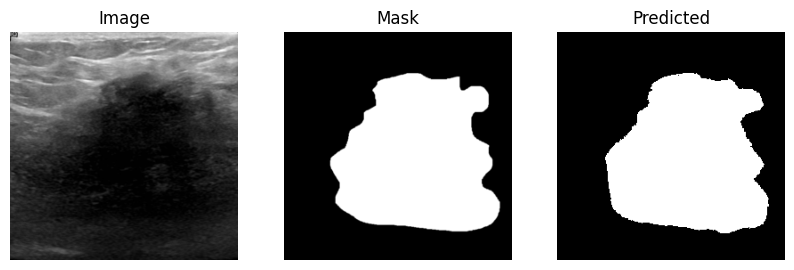

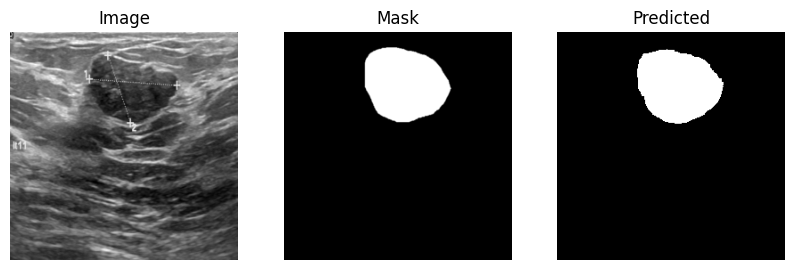

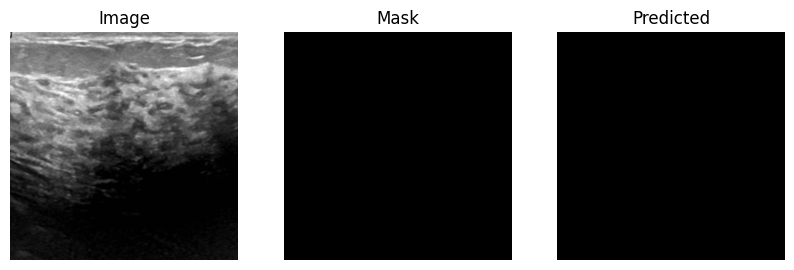

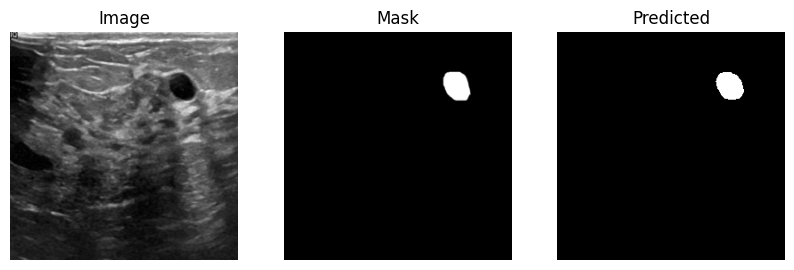

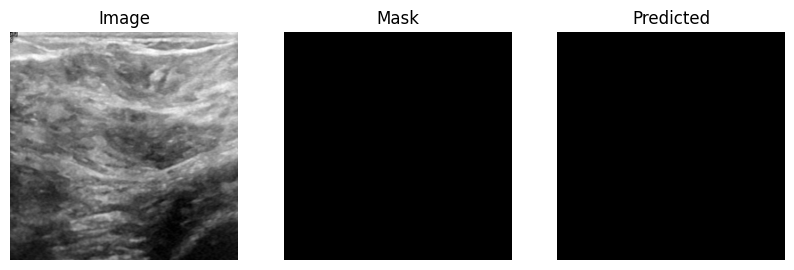

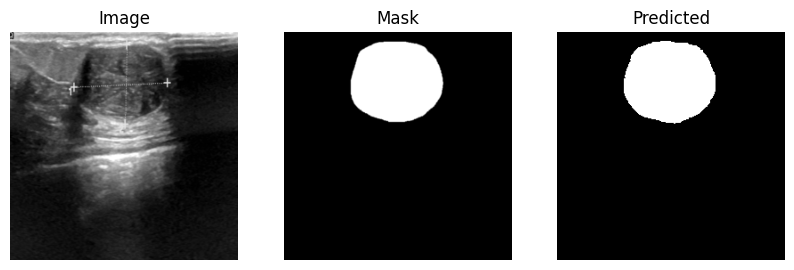

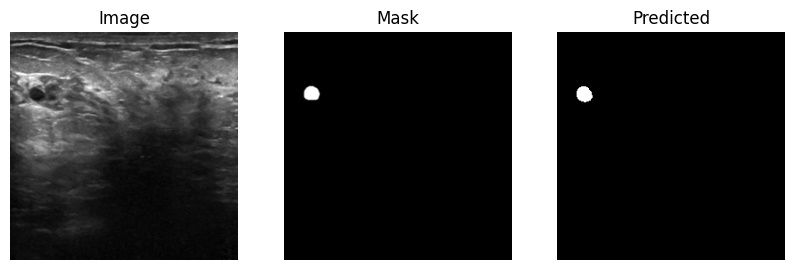

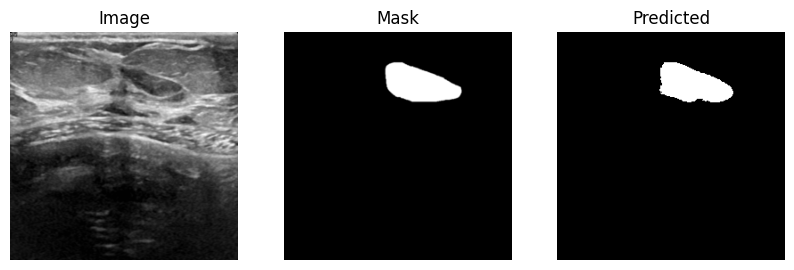

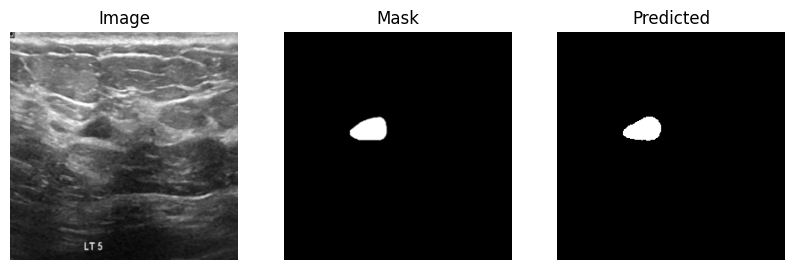

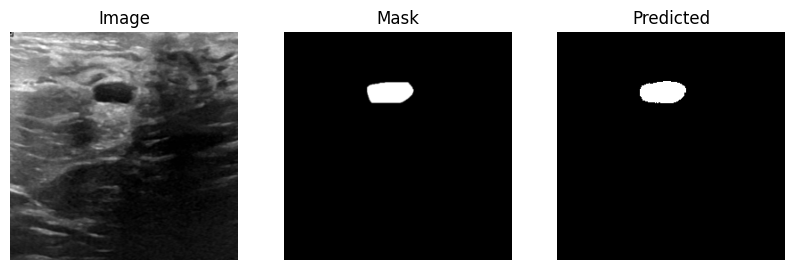

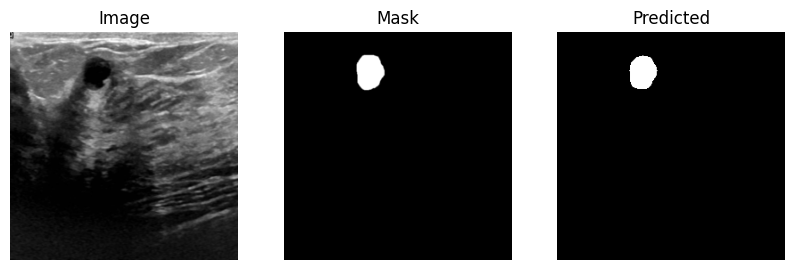

In [27]:
for i in [2, 3, 11, 20, 55, 67, 87, 98, 120, 130, 200]:
    image = train_dataset[i][0]
    mask = train_dataset[i][1]
    im = image.to(device)
    pred = model2(im.unsqueeze(0))
    pred = pred.squeeze()

    plot_subplots(im, mask, pred)

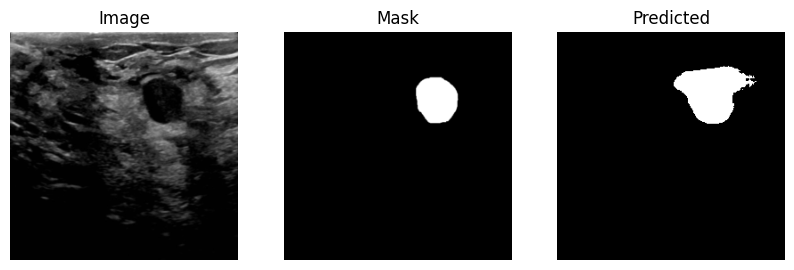

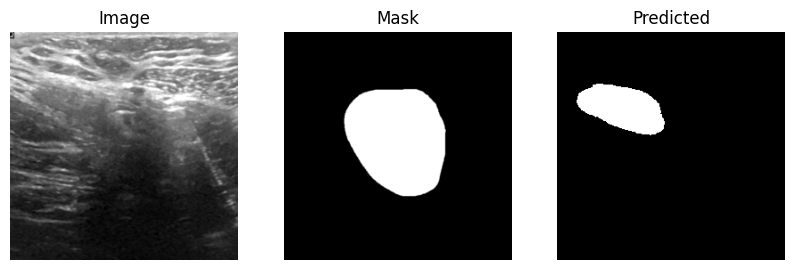

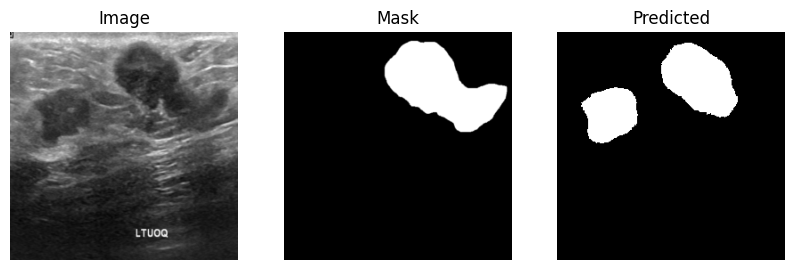

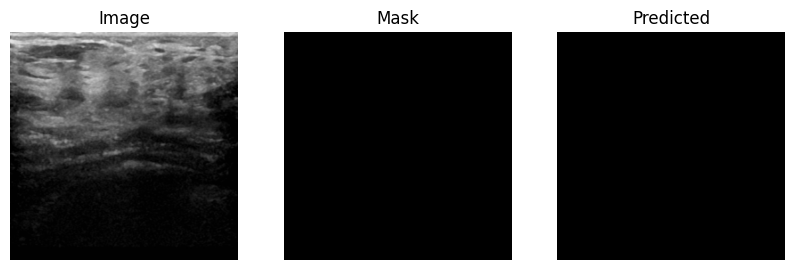

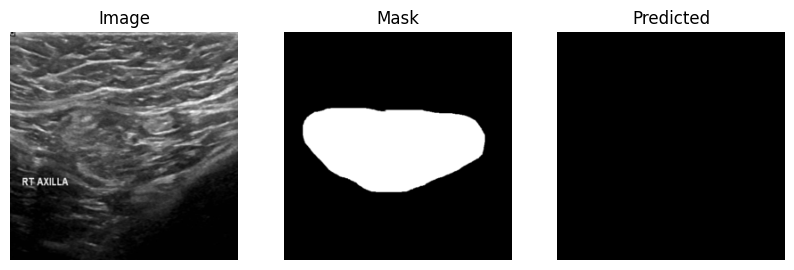

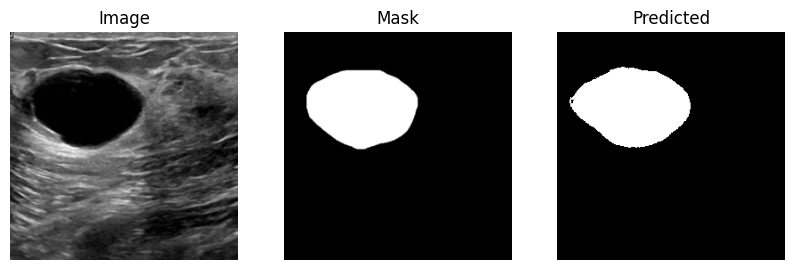

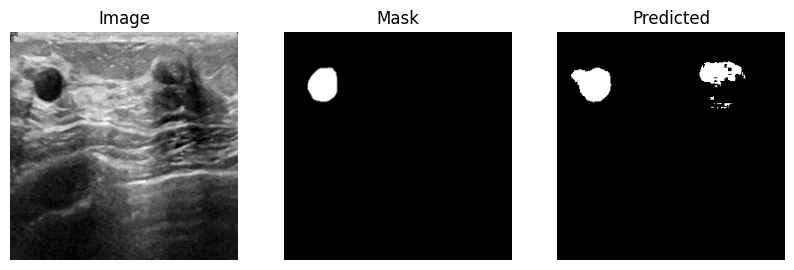

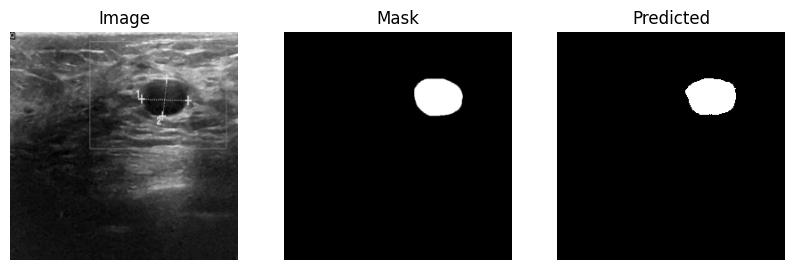

IndexError: single positional indexer is out-of-bounds

In [28]:
for i in [2, 3, 11, 20, 55, 67, 87, 98, 120, 130, 200]:
    image = test_dataset[i][0]
    mask = test_dataset[i][1]
    im = image.to(device)
    pred = model2(im.unsqueeze(0))
    pred = pred.squeeze()

    plot_subplots(im, mask, pred)